#**Project Summary**

Bitcoin values are prediticted over time using the historical timeframe from 2012-2020


In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=4cb7ecff4a3b1332270300aad5db253a02057b5d88b6a731976dec7118d3dc90
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


#Importing Libraries


In [2]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [3]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
#visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

In [5]:
#Building the spark session
sc = SparkContext(appName = "Bitcoin_Analysis")
spark = SparkSession.Builder().getOrCreate()

In [6]:
spark

In [7]:
#Creating SQL Spark session
sqlContext = SQLContext(spark.sparkContext)
sqlContext

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


# Exploratory Data Analysis (EDA)
This part is exploring the given data set to understand the basic data structure, the meaning of values, and the importance of features for building a Bitcoin Trend Analysis.

<br>
The exploratory data analysis will be conducted based on the following process.

1. Import required libraries
2. Upload the data set
3. Understand the data structure
4. Check the samples
5. Investigate missing values
6. Handle outliers
7. Explore the values


In [8]:
#Loading Data to dataframe
df= sqlContext.read.csv('/content/bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv', header='true', inferSchema='true')

In [10]:
df.show(10)

+----------+----+----+----+-----+------------+-----------------+--------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|
+----------+----+----+----+-----+------------+-----------------+--------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|      2.000000019|          4.39|
|1325317980| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318040| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318100| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318160| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318220| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318280| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318340| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318400| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318460| NaN| NaN| NaN|  NaN|       

In [11]:
df.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume_(BTC): double (nullable = true)
 |-- Volume_(Currency): double (nullable = true)
 |-- Weighted_Price: double (nullable = true)



In [12]:
# Count total number of rows
df.count()
# Count the total number of columns
len(df.columns)

1048575

8

In [14]:
#creating a temp view table
df.createOrReplaceTempView('bitstampUSD')
bitstampUSD = sqlContext.sql("select *,from_unixtime(Timestamp) as `dateTime` from bitstampUSD")

# Removing null values
bitstampUSD=bitstampUSD.dropna('any')

In [15]:
# Count total number of rows after removing the null values
bitstampUSD.count()

342169

In [16]:
#Renaming the columns
bitstampUSD=bitstampUSD.withColumnRenamed("Volume_(BTC)", "VolBTC").withColumnRenamed("Volume_(Currency)", "VolCurrency")

In [17]:
#Creating another dataframe to perform Datetime Visualization
DateTime_df= bitstampUSD


In [18]:
#Splitting the dataframe by required columns
splitDF = DateTime_df.withColumn("date",split(col("dateTime")," ").getItem(0))
splitDF = splitDF.withColumn("time",split(col("dateTime")," ").getItem(1))


In [19]:
#Splitting the dataframe by required columns
splitDFHour = splitDF.withColumn("hour",split(col("time"),":").getItem(0))

In [20]:
#Arranging Dataframe with column date and time and day_of_week
splitDFHour= splitDFHour.withColumn("date",splitDFHour["date"].cast(DateType())).withColumn("hour",splitDFHour["hour"].cast(DoubleType())).withColumn("dateTime",splitDFHour["dateTime"].cast(DateType()))
splitDFHour=splitDFHour.withColumn('day_of_week',dayofweek(splitDFHour.date))

In [21]:
splitDFWithYear = splitDFHour.withColumn("year",split(col("date"),"-").getItem(0))
splitDFWithYear.show(10)

+----------+----+----+----+-----+-----------+-----------+--------------+----------+----------+--------+----+-----------+----+
| Timestamp|Open|High| Low|Close|     VolBTC|VolCurrency|Weighted_Price|  dateTime|      date|    time|hour|day_of_week|year|
+----------+----+----+----+-----+-----------+-----------+--------------+----------+----------+--------+----+-----------+----+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.000000019|          4.39|2011-12-31|2011-12-31|07:52:00| 7.0|          7|2011|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|     210.72|          4.39|2011-12-31|2011-12-31|15:50:00|15.0|          7|2011|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.3803375|   4.526411498|2011-12-31|2011-12-31|16:59:00|16.0|          7|2011|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|      41.22|          4.58|2011-12-31|2011-12-31|17:00:00|17.0|          7|2011|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|    6.87916|          4.58|2012-01-01|2012-01-01|04:16:00| 4.0|          

In [22]:
# Spark to Pandas dataframe
pandas_converted=splitDFWithYear.toPandas()

#Data Visualisation


In [24]:
#Getting the values in list so that we can plot and visualize it
hour=pandas_converted["hour"].values.tolist()
weighted_price=pandas_converted["Weighted_Price"].values.tolist()
volume_BTC=pandas_converted["VolBTC"].values.tolist()
date_of_week=pandas_converted["day_of_week"].values.tolist()
year=pandas_converted["year"].values.tolist()

<ipython-input-25-a29e8444239d>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr=pandas_converted.corr()


<Axes: >

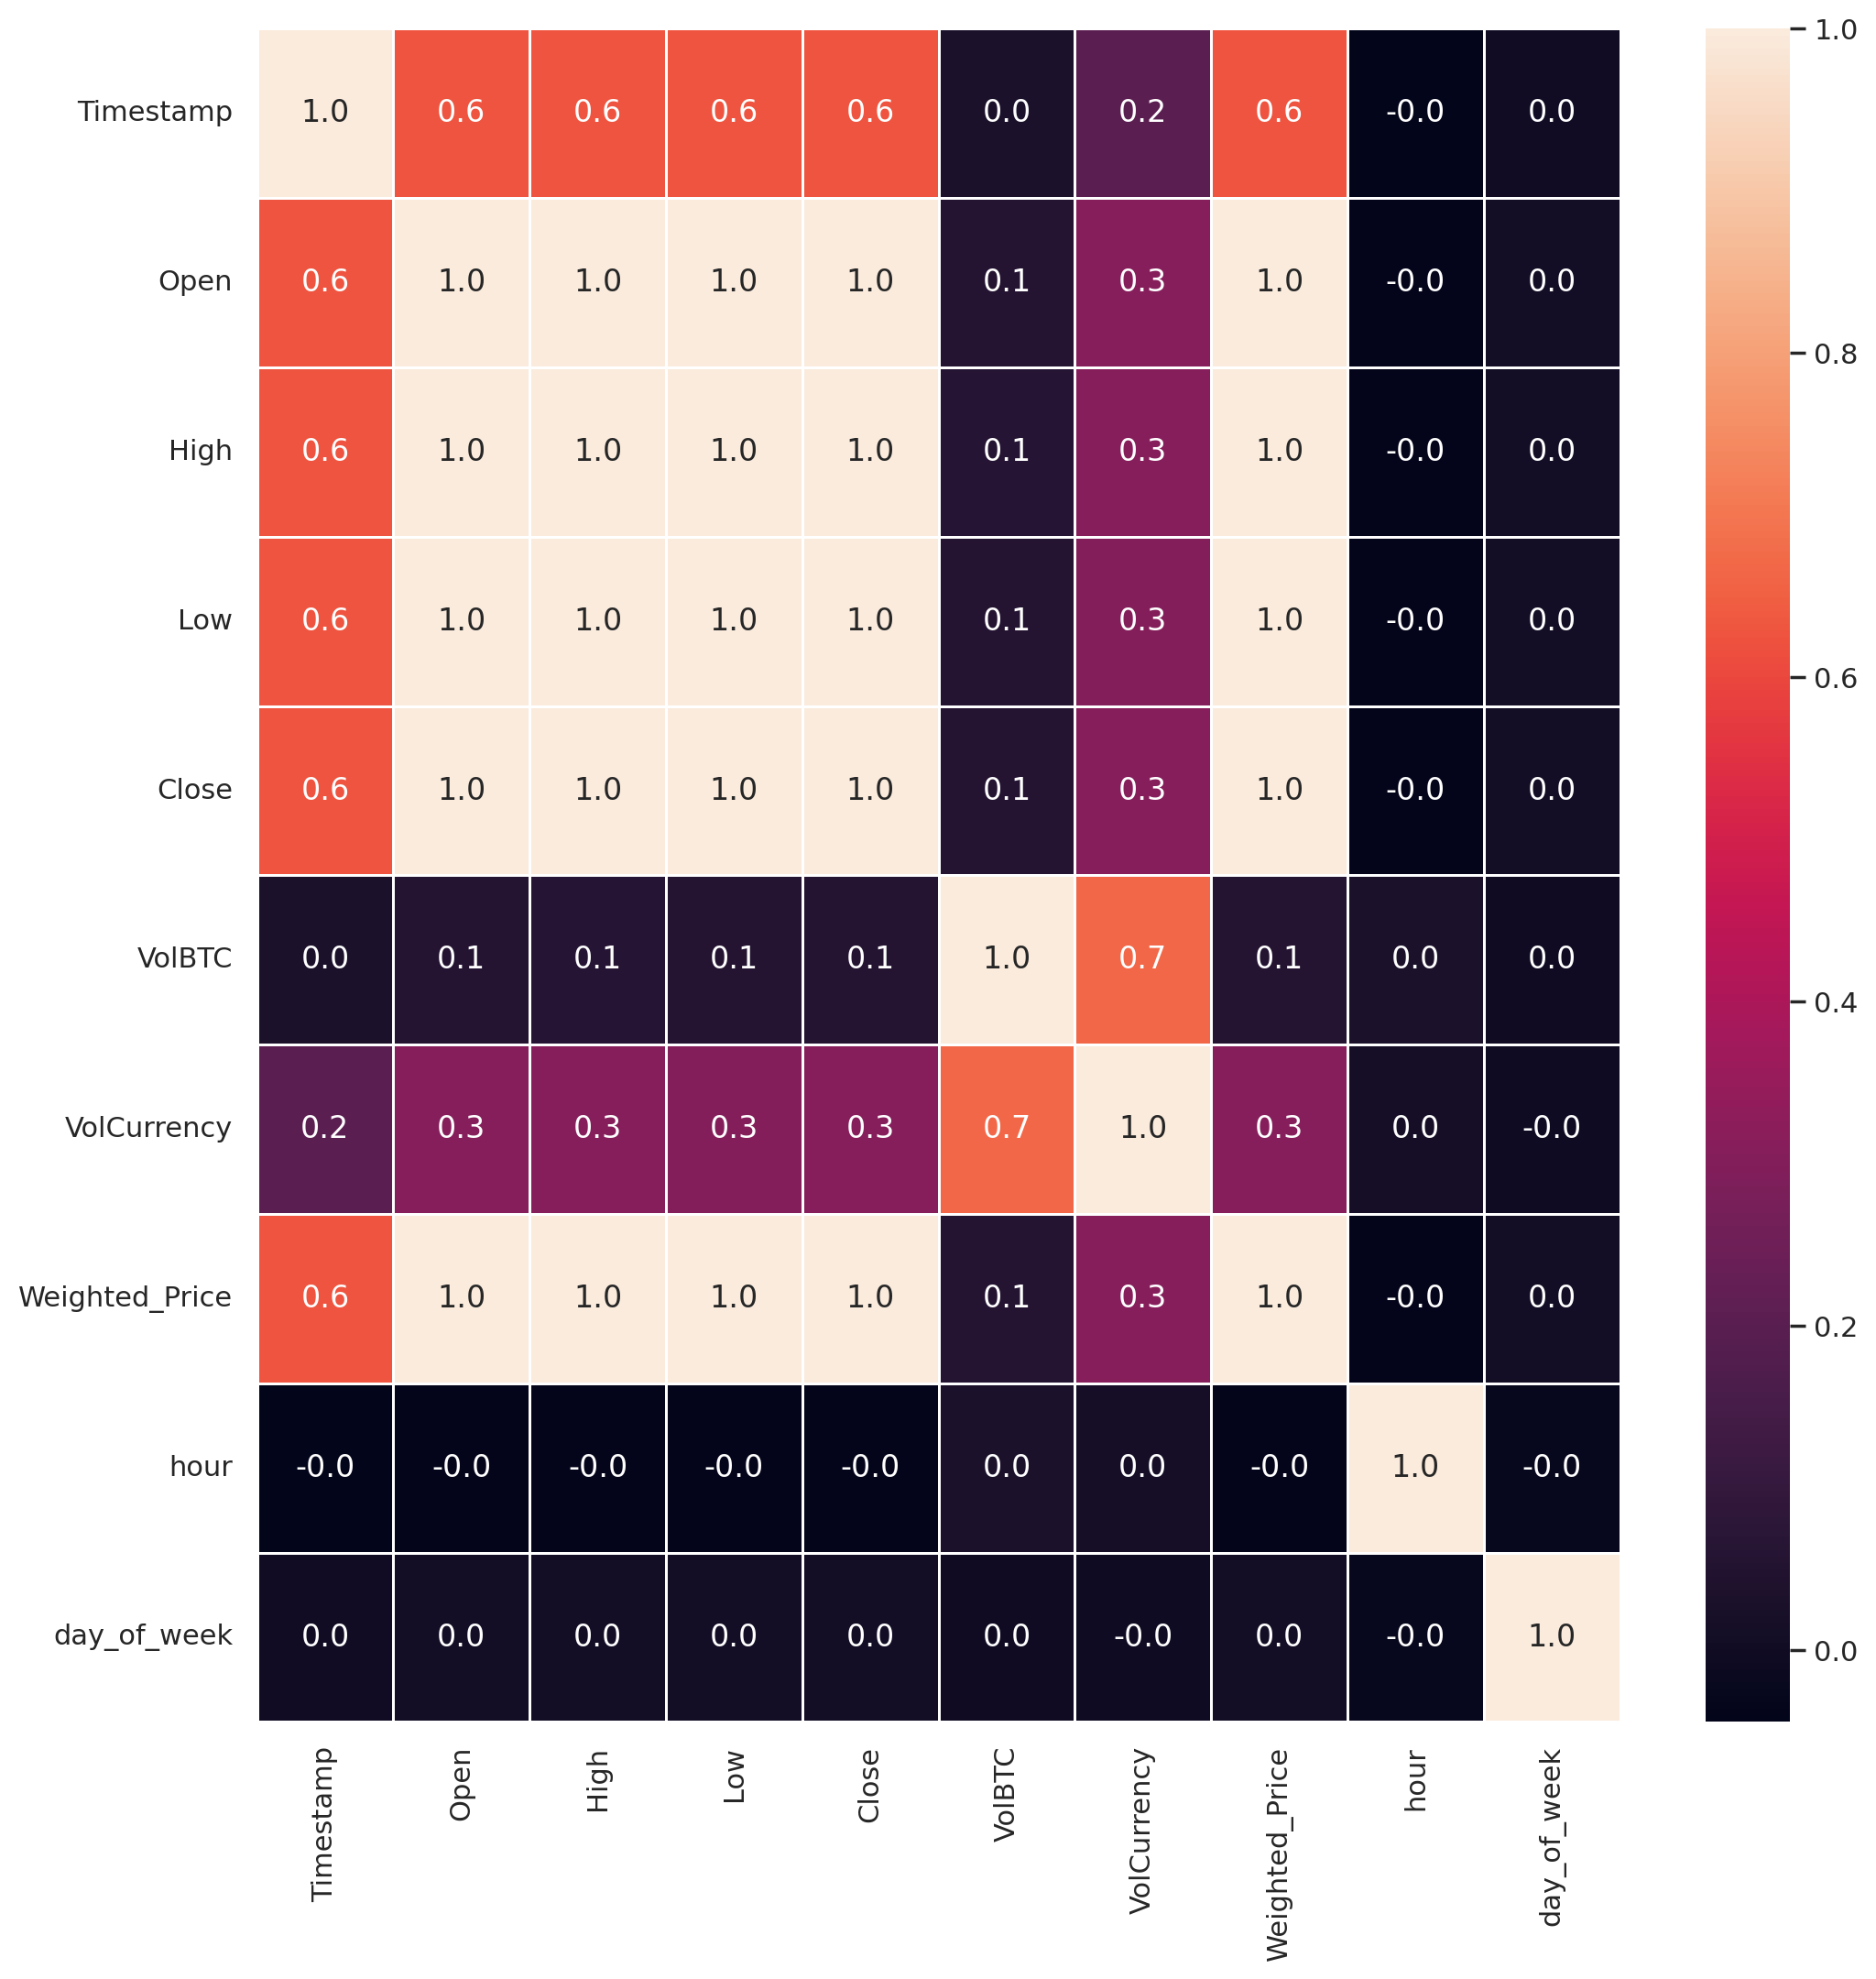

In [25]:
corr=pandas_converted.corr()
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corr,annot=True,linewidths=.5, fmt= '.1f',ax=ax)

<Axes: xlabel='VolBTC', ylabel='VolCurrency'>

Text(0.5, 0, 'BTC Volume')

Text(0, 0.5, 'Currency Volume')

Text(0.5, 1.0, 'BTC-Currency Scatter Plot')

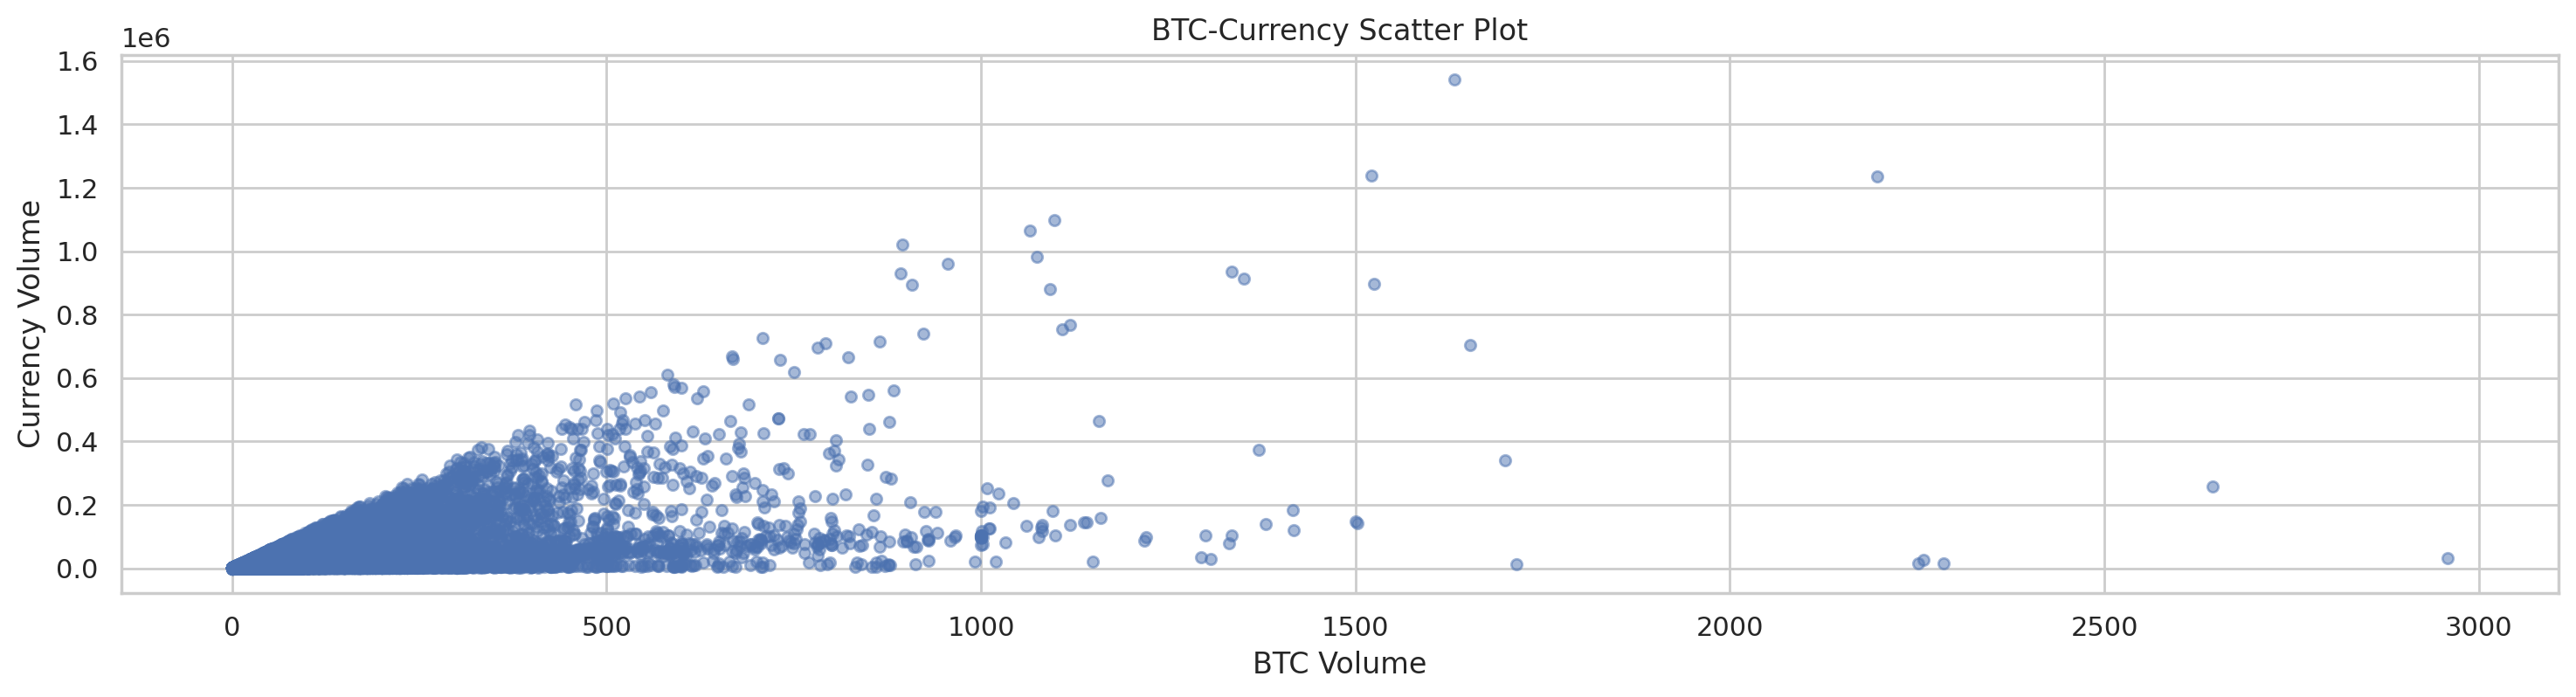

In [26]:
# Scatter Plot usage by Matplotlib
# x = open, y = close
pandas_converted.plot(kind='scatter', x='VolBTC', y='VolCurrency',alpha = 0.5)
plt.xlabel('BTC Volume')
plt.ylabel('Currency Volume')
plt.title('BTC-Currency Scatter Plot')
plt.show()

<Figure size 1600x400 with 0 Axes>

<Axes: >

<Axes: >

Text(0.5, 0, 'Time')

Text(0, 0.5, 'price at the start of the time window')

Text(0.5, 1.0, 'Line plot')

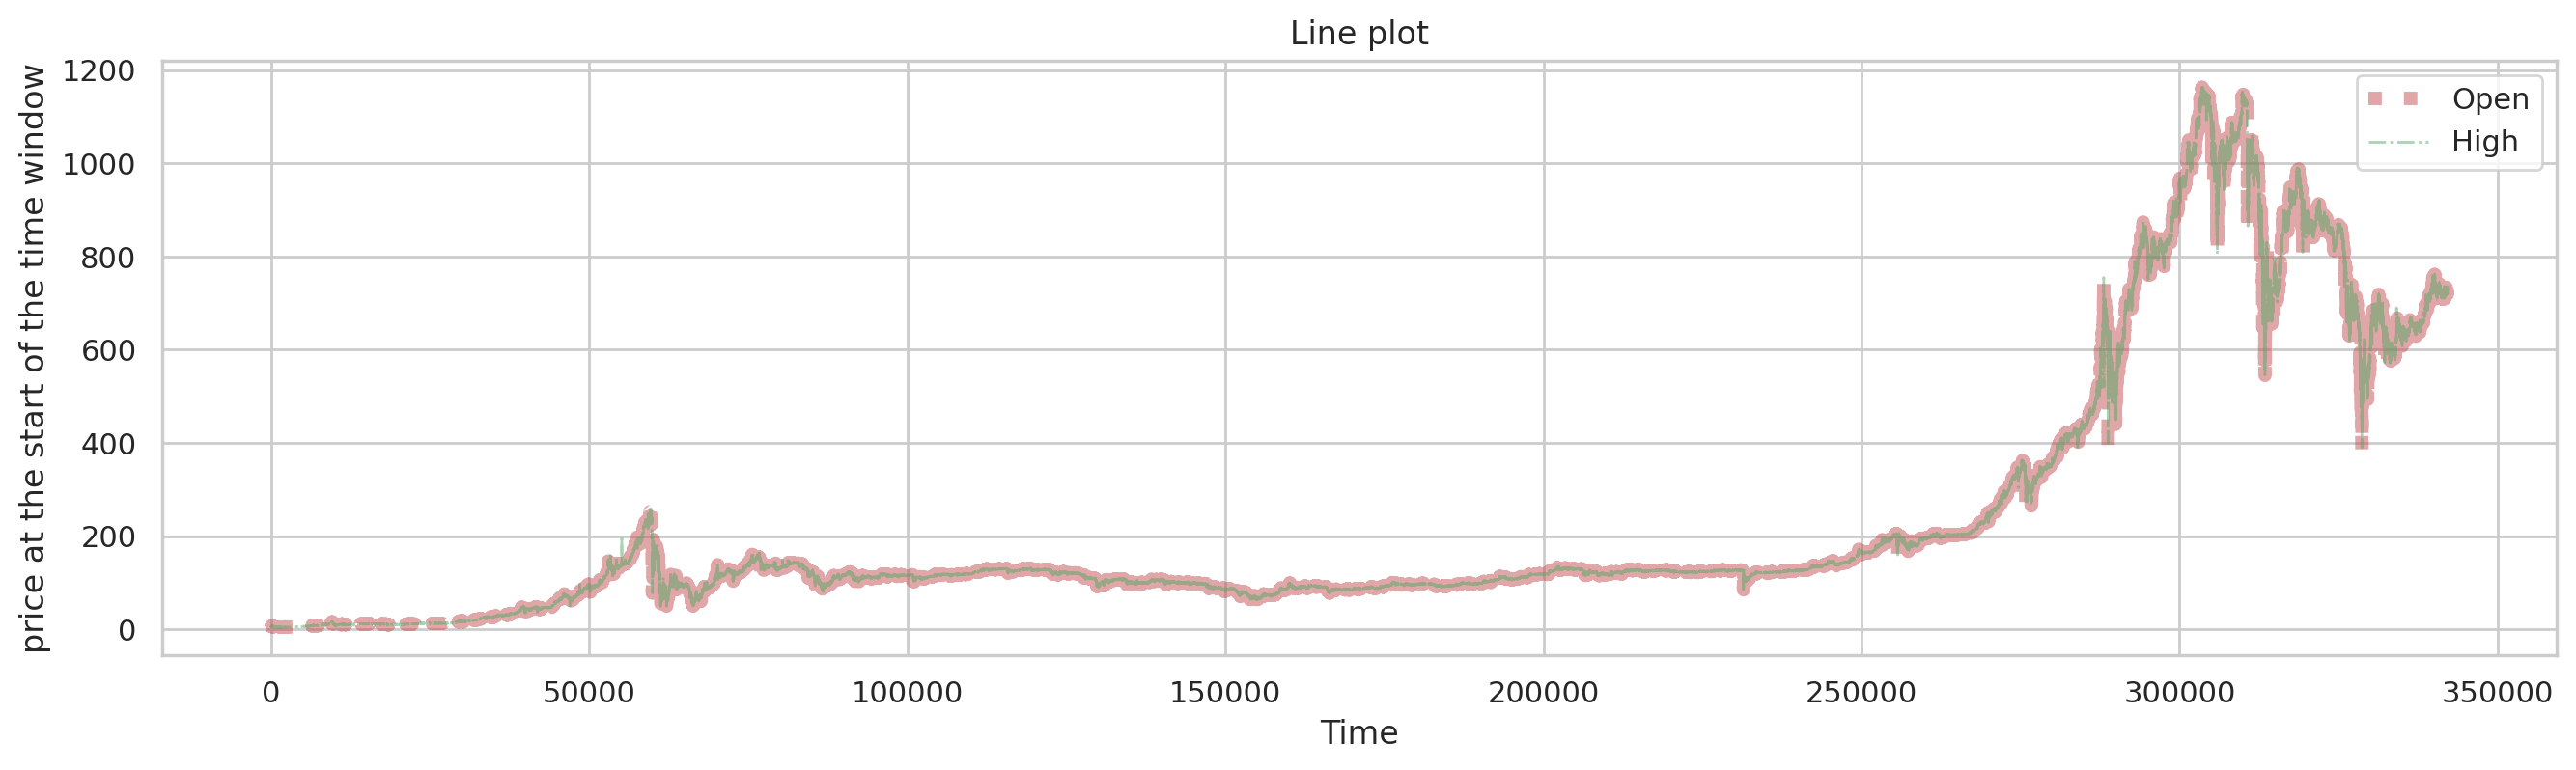

In [27]:
# Line Plot usage by Matplotlib plotting Open with High with Time on X axis
# color = color, label = label, linewidth = width of line, alpha = opacity, grid = gray square background, linestyle = sytle of line

plt.figure(figsize=(16,4))
pandas_converted.Open.plot(kind='line', color='r', label='Open', alpha=0.5, linewidth=5, grid=True, linestyle=':')
pandas_converted.High.plot(color='g', label='High', linewidth=1, alpha=0.5, grid=True, linestyle='-.')
plt.legend(loc='upper right') #legend put label into plot
plt.xlabel('Time')
plt.ylabel('price at the start of the time window')
plt.title('Line plot')
plt.show()

<Axes: ylabel='Frequency'>

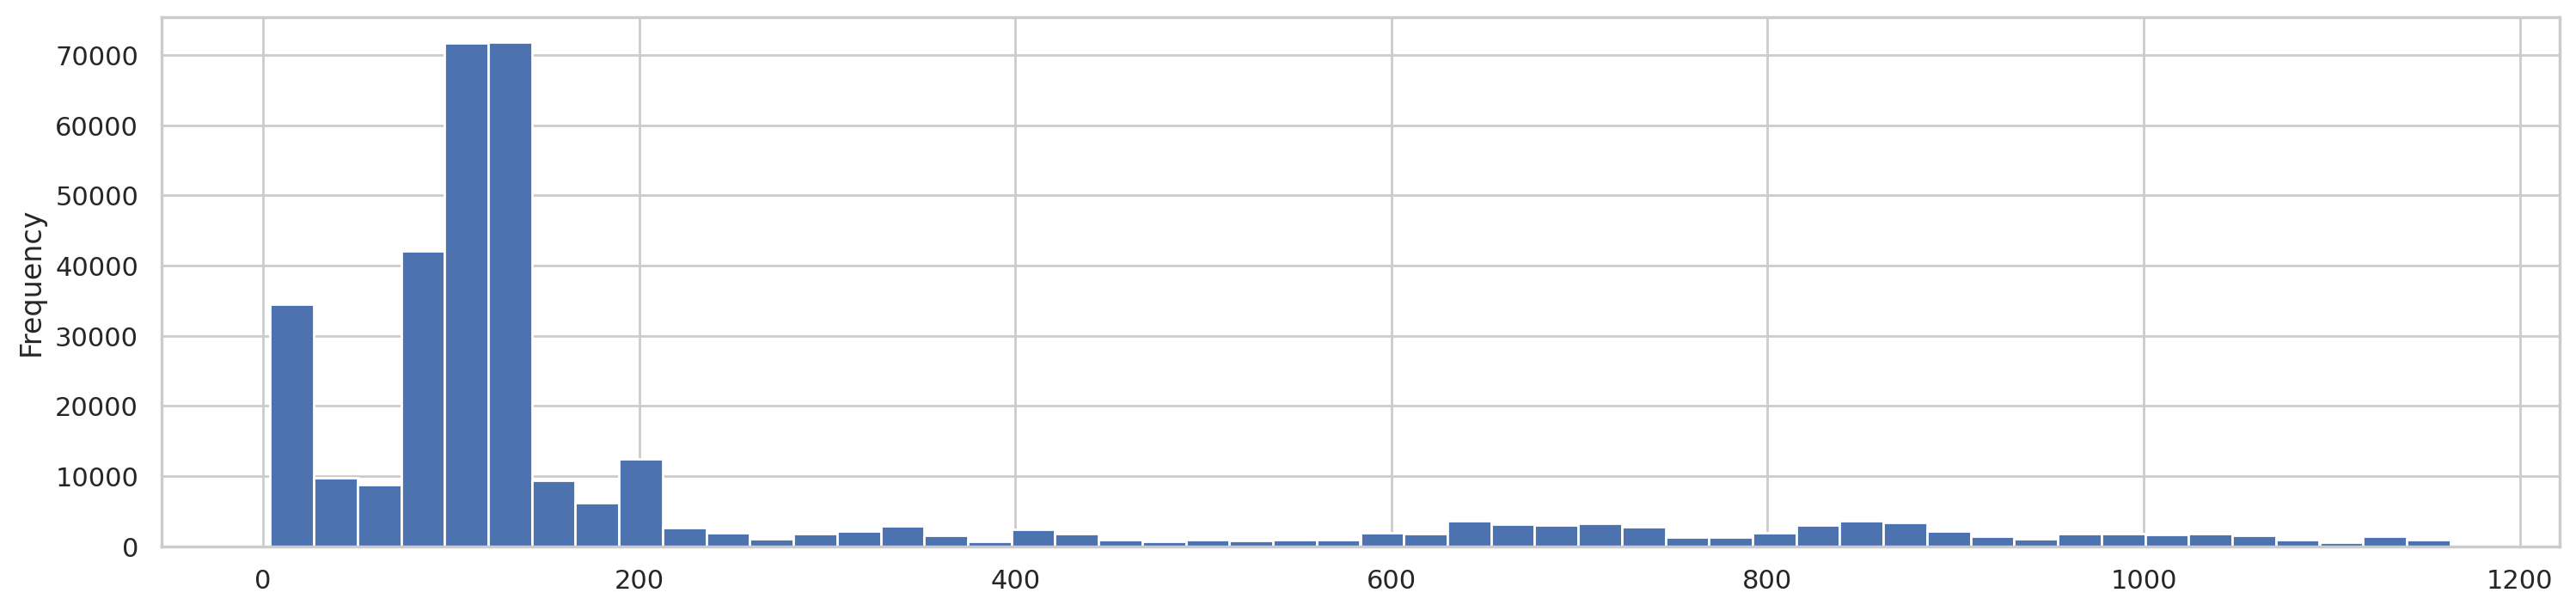

In [28]:
#Histogram plot of Open price
pandas_converted.Open.plot(kind='hist', bins=50)

Text(0.5, 0, 'hour')

Text(0, 0.5, 'Weighted_Price')

Text(0.5, 1.0, 'Price by Hour')

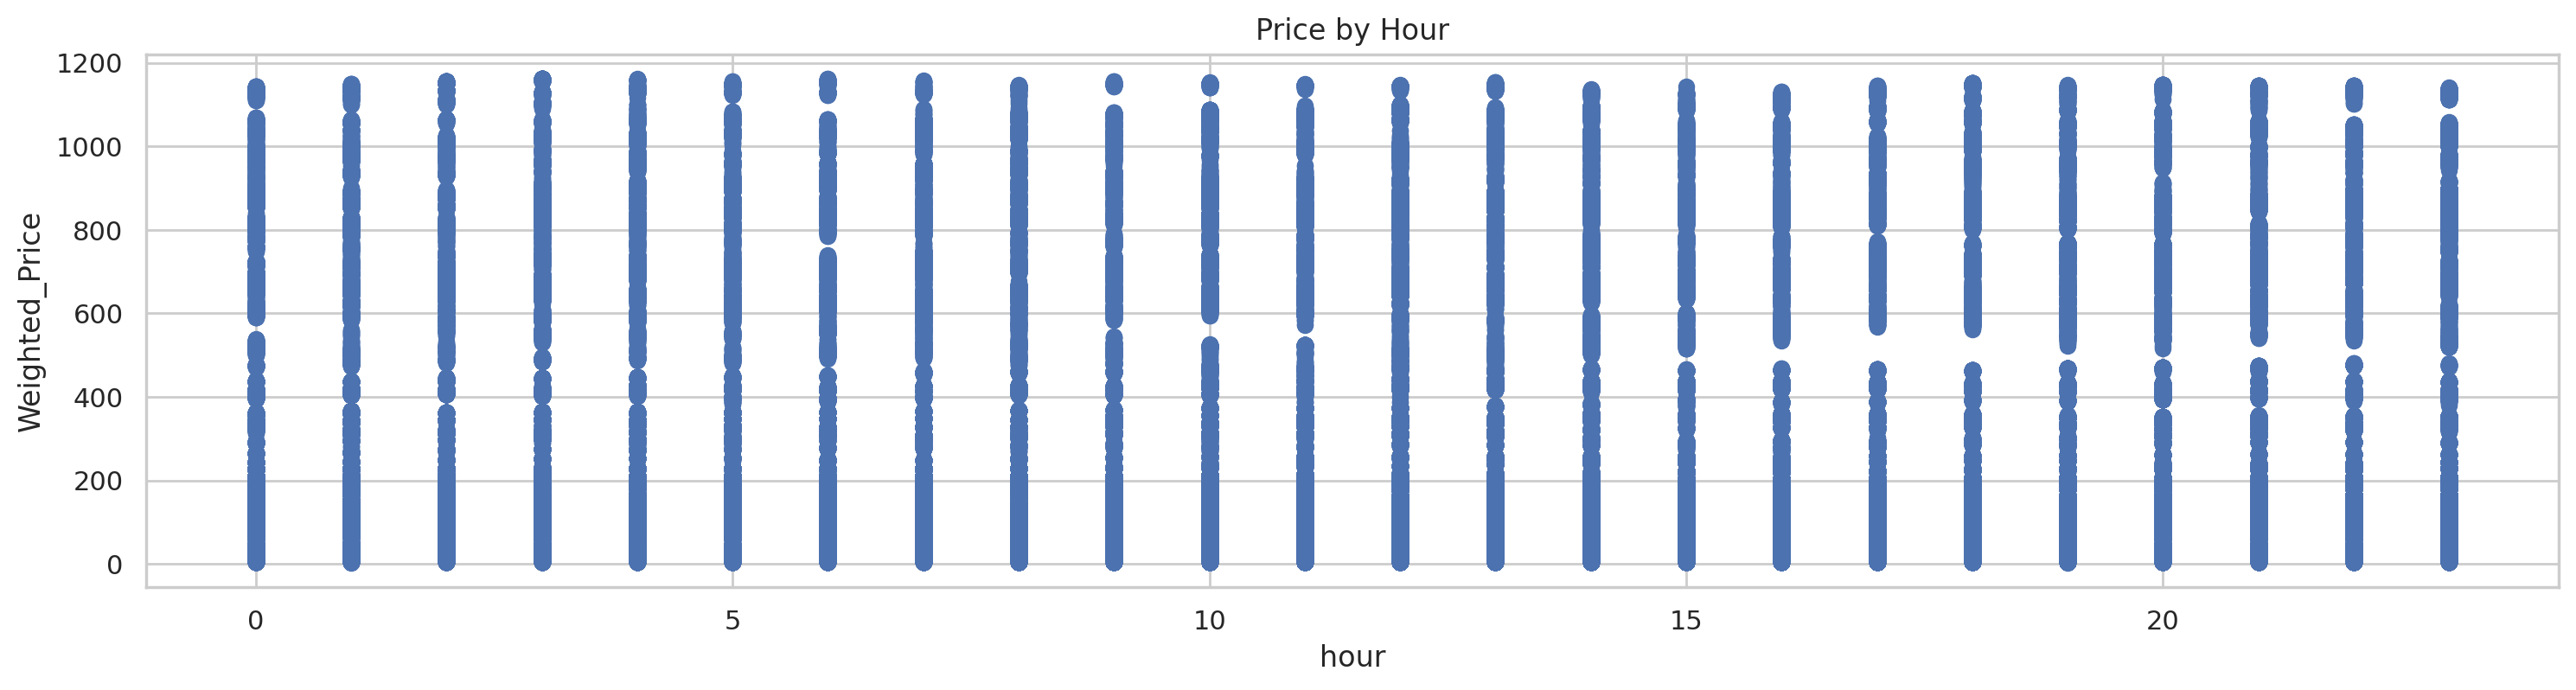

In [29]:
#Plot of Weighted_price per hour in scatter plot using Matplotlib
plt.plot(hour,weighted_price , 'bo')
#group1_pd.plot(kind='scatter', x='hour', y='Weighted_Price',alpha = 0.01)
plt.xlabel('hour')
plt.ylabel('Weighted_Price')
plt.title('Price by Hour')
plt.show()

Text(0.5, 0, 'day_of_week')

Text(0, 0.5, 'Weighted_Price')

Text(0.5, 1.0, 'Price By Week')

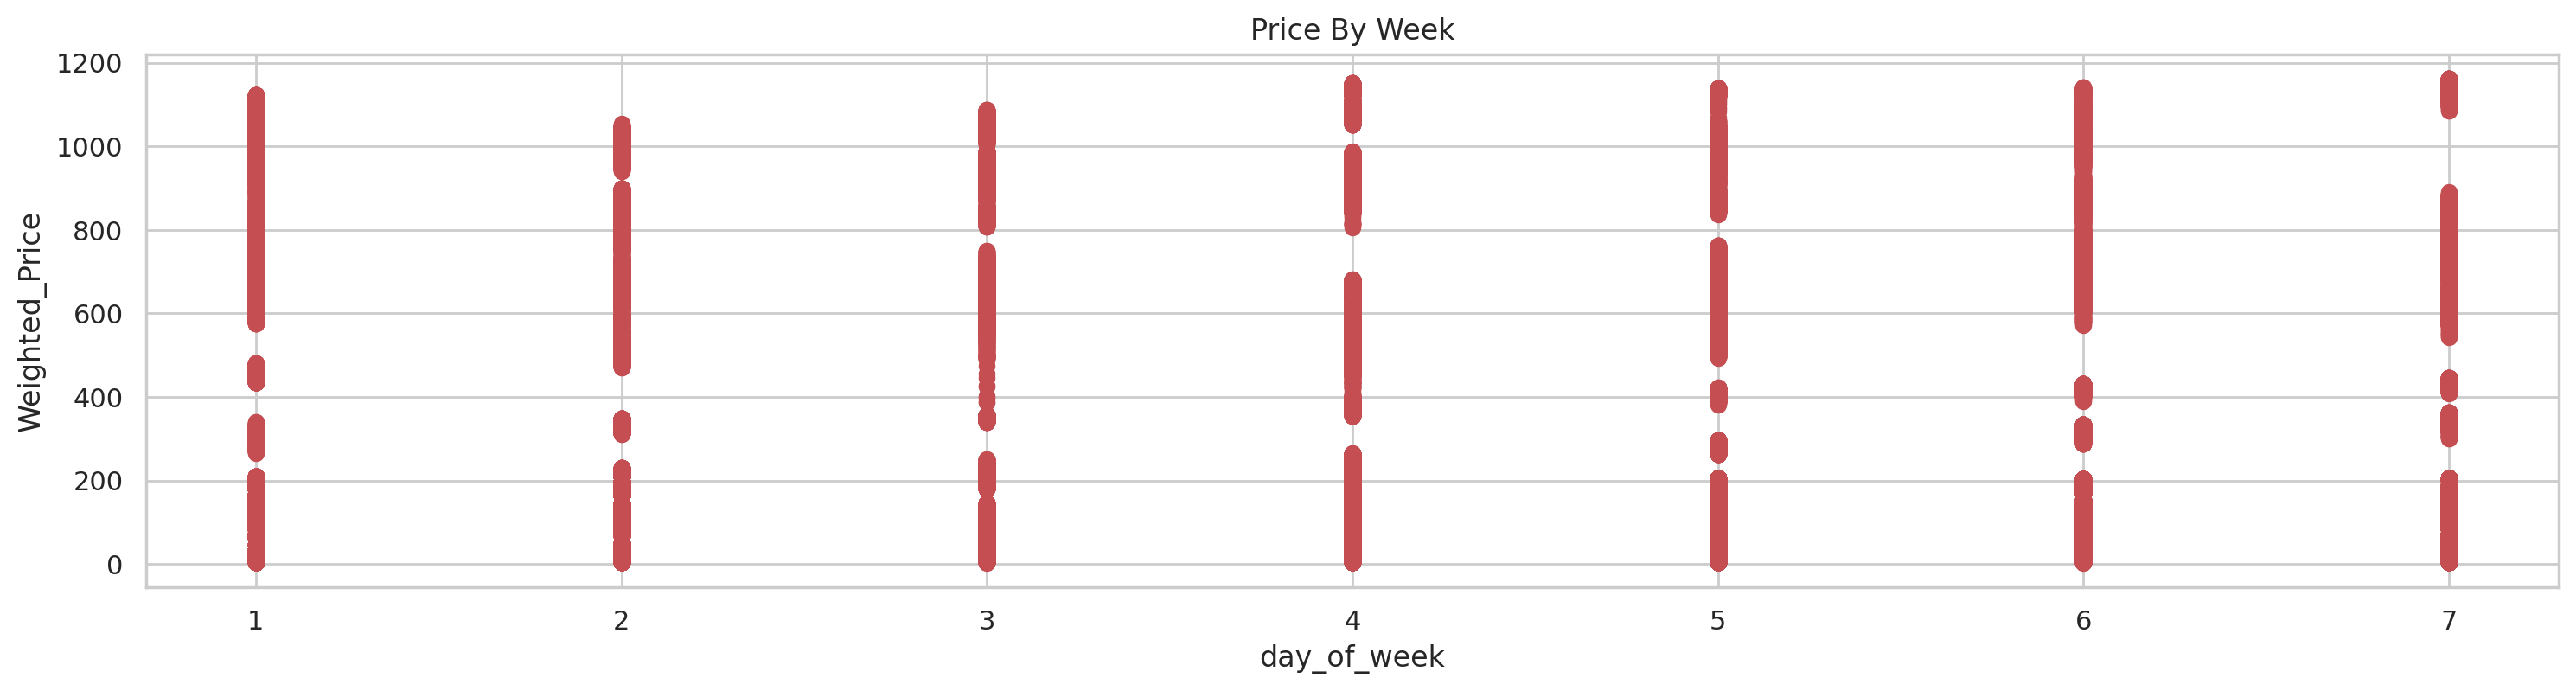

In [30]:
#Plot of Weighted_price per week in scatter plot using Matplotlib
plt.plot(date_of_week, weighted_price, 'ro')
#group1_pd.plot(kind='scatter', x='hour', y='Weighted_Price',alpha = 0.01)
plt.xlabel('day_of_week')
plt.ylabel('Weighted_Price')
plt.title('Price By Week')
plt.show()

In [33]:
from pyspark.sql import functions as F

bitstampUSD = bitstampUSD.withColumn("date", F.to_date("dateTime"))

# Create or Replace Temp View with the new column
bitstampUSD.createOrReplaceTempView('bitstampUSD')

# Now perform the aggregation using SQL
daily_aggregated_data = sqlContext.sql("""
    SELECT
        date,
        AVG(Open) AS Open,
        AVG(High) AS High,
        AVG(Low) AS Low,
        AVG(Close) AS Close,
        SUM(VolBTC) AS VolBTC,
        SUM(VolCurrency) AS VolCurrency,
        AVG(Weighted_Price) AS Weighted_Price
    FROM
        bitstampUSD
    GROUP BY
        date
    ORDER BY
        date
""")

# Show the aggregated DataFrame
daily_aggregated_data.show(10)

+----------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+
|      date|             Open|             High|              Low|            Close|           VolBTC|       VolCurrency|   Weighted_Price|
+----------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+
|2011-12-31|            4.465|           4.4825|            4.465|           4.4825|       95.3178781|425.32033751899996|     4.4716028745|
|2012-01-01|4.806666666666667|4.806666666666667|4.806666666666667|4.806666666666667|           21.602|105.77915999999999|4.806666666666667|
|2012-01-02|              5.0|              5.0|              5.0|              5.0|           19.048|             95.24|              5.0|
|2012-01-03|           5.2525|           5.2525|           5.2525|           5.2525|88.03728091999999|      464.80520952|           5.2525|
|2012-01-04|        

In [34]:
# put features into a feature vector column
assembler = VectorAssembler(inputCols=['Open','High', 'VolBTC', 'VolCurrency','Weighted_Price'], outputCol="features")
assembled_df = assembler.transform(bitstampUSD)
assembled_df.show(10, truncate= False)

+----------+----+----+----+-----+-----------+-----------+--------------+-------------------+----------+----------------------------------------------+
|Timestamp |Open|High|Low |Close|VolBTC     |VolCurrency|Weighted_Price|dateTime           |date      |features                                      |
+----------+----+----+----+-----+-----------+-----------+--------------+-------------------+----------+----------------------------------------------+
|1325317920|4.39|4.39|4.39|4.39 |0.45558087 |2.000000019|4.39          |2011-12-31 07:52:00|2011-12-31|[4.39,4.39,0.45558087,2.000000019,4.39]       |
|1325346600|4.39|4.39|4.39|4.39 |48.0       |210.72     |4.39          |2011-12-31 15:50:00|2011-12-31|[4.39,4.39,48.0,210.72,4.39]                  |
|1325350740|4.5 |4.57|4.5 |4.57 |37.86229723|171.3803375|4.526411498   |2011-12-31 16:59:00|2011-12-31|[4.5,4.57,37.86229723,171.3803375,4.526411498]|
|1325350800|4.58|4.58|4.58|4.58 |9.0        |41.22      |4.58          |2011-12-31 17:00:00|20

#1. Linear Regression Model

**What is Linear Regression?** <br>
It is one of the popular machine learning algorithms used to find frequent relationships between the dependent and independent variables. <br>
<br>
**Is Linear Regression used in Bitcoin Trend Analysis?** <br>
Linear regression helps in identifying the overall trend in historical price data. By fitting a linear regression line to the historical price points, analysts can visually assess whether the trend is upward (bullish), downward (bearish), or relatively flat.

**How is the Bitcoin Trendanalysis built using Linear regression?** <br>
1. Data Preprocessing
> A) Preparation for Modeling <br>
> B) Train and test dataset
2. Data Modeling
> A) `linearRegression()` <br>
3. Evaluation
> A) Find the best parameters <br>
> B) Predicted Price and Weighted Price <br>
> C) RootMean Square

In [35]:
total_rows = assembled_df.count()

# Calculate the number of rows for the training set (total minus 10)
train_rows = total_rows - 10

# Select all but the last 10 rows for the training set
train_data = assembled_df.limit(train_rows)

# Select only the last 10 rows for the test set
# To do this, we skip the first 'train_rows' rows and take the rest
test_data = assembled_df.orderBy(assembled_df.columns).tail(10)


In [36]:
lr = (LinearRegression(featuresCol='features' , labelCol="Weighted_Price", predictionCol='Predicted_price',
                               maxIter=100, regParam=0.3, elasticNetParam=0.8, standardization=False))

In [37]:
linearModel = lr.fit(train_data)

In [38]:
test_data_df = spark.createDataFrame(test_data)

In [39]:
# Generate predictions
predictions = linearModel.transform(test_data_df)
# Select the columns and store in a variable
pred_data= predictions.select("Predicted_price", "Weighted_Price").show(10)

+-----------------+--------------+
|  Predicted_price|Weighted_Price|
+-----------------+--------------+
|728.8645289776432|    729.099358|
|728.9142216569854|   729.3566123|
|729.5079599290792|   729.5570372|
|730.4948238385908|   730.8474942|
|731.9058889568385|    734.054301|
|734.0322363456398|    734.005698|
|733.6738538802706|   732.9914991|
|733.9281173103851|   734.0634883|
|731.4773547135726|   731.3727073|
|733.0284670215345|   733.3693026|
+-----------------+--------------+



**Last 60 Days**

In [40]:
evaluator = RegressionEvaluator(
    labelCol="Weighted_Price", predictionCol="Predicted_price", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.74867


In [41]:
last_60_rows = train_data.tail(60)

# Convert the list of Row objects back into a DataFrame
last_60_rows_df = spark.createDataFrame(last_60_rows)

In [42]:
linearModel1 = lr.fit(last_60_rows_df)

In [43]:
# Generate predictions
predictions1 = linearModel1.transform(test_data_df)
# Select the columns and store in a variable
pred_data= predictions1.select("Predicted_price", "Weighted_Price").show(10)

+-----------------+--------------+
|  Predicted_price|Weighted_Price|
+-----------------+--------------+
|729.0556001675928|    729.099358|
|729.2802955139322|   729.3566123|
|729.5355966276295|   729.5570372|
|730.6903654050542|   730.8474942|
|733.7391770584784|    734.054301|
|733.6897669546983|    734.005698|
|732.7928796943746|   732.9914991|
|   733.7282742577|   734.0634883|
|731.2765067779862|   731.3727073|
|733.0850218393057|   733.3693026|
+-----------------+--------------+



**Last 30 Days**

In [44]:
evaluator1 = RegressionEvaluator(
    labelCol="Weighted_Price", predictionCol="Predicted_price", metricName="rmse")
rmse = evaluator1.evaluate(predictions1)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.217691


In [45]:
last_30_rows = train_data.tail(30)

# Convert the list of Row objects back into a DataFrame
last_30_rows_df = spark.createDataFrame(last_30_rows)

In [46]:
linearModel2 = lr.fit(last_30_rows_df)

In [47]:
predictions3 = linearModel2.transform(test_data_df)
# Select the columns and store in a variable
pred_data= predictions3.select("Predicted_price", "Weighted_Price").show(10)

+-----------------+--------------+
|  Predicted_price|Weighted_Price|
+-----------------+--------------+
|729.2191084897619|    729.099358|
|729.4413294488577|   729.3566123|
|729.6428793298834|   729.5570372|
|  730.75110976723|   730.8474942|
|733.3025911374841|    734.054301|
|733.5272362970273|    734.005698|
|732.6618568519341|   732.9914991|
|733.5752506872676|   734.0634883|
|731.2557969585706|   731.3727073|
|732.9533360535556|   733.3693026|
+-----------------+--------------+



In [48]:
evaluator2 = RegressionEvaluator(
    labelCol="Weighted_Price", predictionCol="Predicted_price", metricName="rmse")
rmse = evaluator2.evaluate(predictions3)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.369582


#2. GBT Regression
Gradient Boosted Trees (GBT) is an ensemble learning algorithm that builds a predictive model in the form of a collection of decision trees.

In [49]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(featuresCol="features",\
                           labelCol="Weighted_Price",\
                           predictionCol="Predicted_Price",\
                           maxDepth=5,\
                           subsamplingRate=0.8)

model_gbt = gbt.fit(train_data)
predictions_gbt_test = model_gbt.transform(test_data_df)
predictions_gbt_test.select("Predicted_Price", "Weighted_Price").show(10)
        #predictions_gbt_train = model_gbt.transform(df_train)

        # RMSE is used as evaluation metric
evaluator = RegressionEvaluator(predictionCol="Predicted_Price",\
                                        labelCol="Weighted_Price",\
                                        metricName ="rmse")
RMSE_gbt_test= evaluator.evaluate(predictions_gbt_test)
        #RMSE_gbt_train = evaluator.evaluate(predictions_gbt_train)

+-----------------+--------------+
|  Predicted_Price|Weighted_Price|
+-----------------+--------------+
|688.9946314301155|    729.099358|
|690.3306398832452|   729.3566123|
|688.5221516023112|   729.5570372|
|688.3224224763751|   730.8474942|
|684.2271575196239|    734.054301|
|801.9916656932893|    734.005698|
|801.7160824640947|   732.9914991|
|800.9814159909084|   734.0634883|
|688.3224224763751|   731.3727073|
|803.6520808045478|   733.3693026|
+-----------------+--------------+



In [50]:
RMSE_gbt_test

54.518408403583514

#3. Time Series Analysis
Time series analysis is a common approach for studying and predicting Bitcoin trends, given the temporal nature of cryptocurrency price data

In [51]:
import numpy as np
import pandas as pd
import matplotlib.dates as md
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime as dt
import datetime,pytz

from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
from xgboost import plot_importance, plot_tree

from scipy import stats
from scipy.stats import boxcox

import statsmodels.api as sm
from itertools import product

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from numpy.linalg import LinAlgError

In [52]:
#define a conversion function for the native timestamps in the csv file
def dateparse (time_in_secs):
    return pytz.utc.localize(datetime.datetime.fromtimestamp(float(time_in_secs)))

In [53]:
data = pd.read_csv('/content/bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv',parse_dates=[0], date_parser=dateparse)

In [54]:
data['Volume_(BTC)'].fillna(value=0, inplace=True)
data['Volume_(Currency)'].fillna(value=0, inplace=True)
data['Weighted_Price'].fillna(value=0, inplace=True)

# next we need to fix the OHLC (open high low close) data which is a continuous timeseries so
# lets fill forwards those values...
data['Open'].fillna(method='ffill', inplace=True)
data['High'].fillna(method='ffill', inplace=True)
data['Low'].fillna(method='ffill', inplace=True)
data['Close'].fillna(method='ffill', inplace=True)

<Axes: >

<Axes: >

<Axes: >

<Axes: >

Text(0.5, 0.98, 'Decomposition of Prices Data')

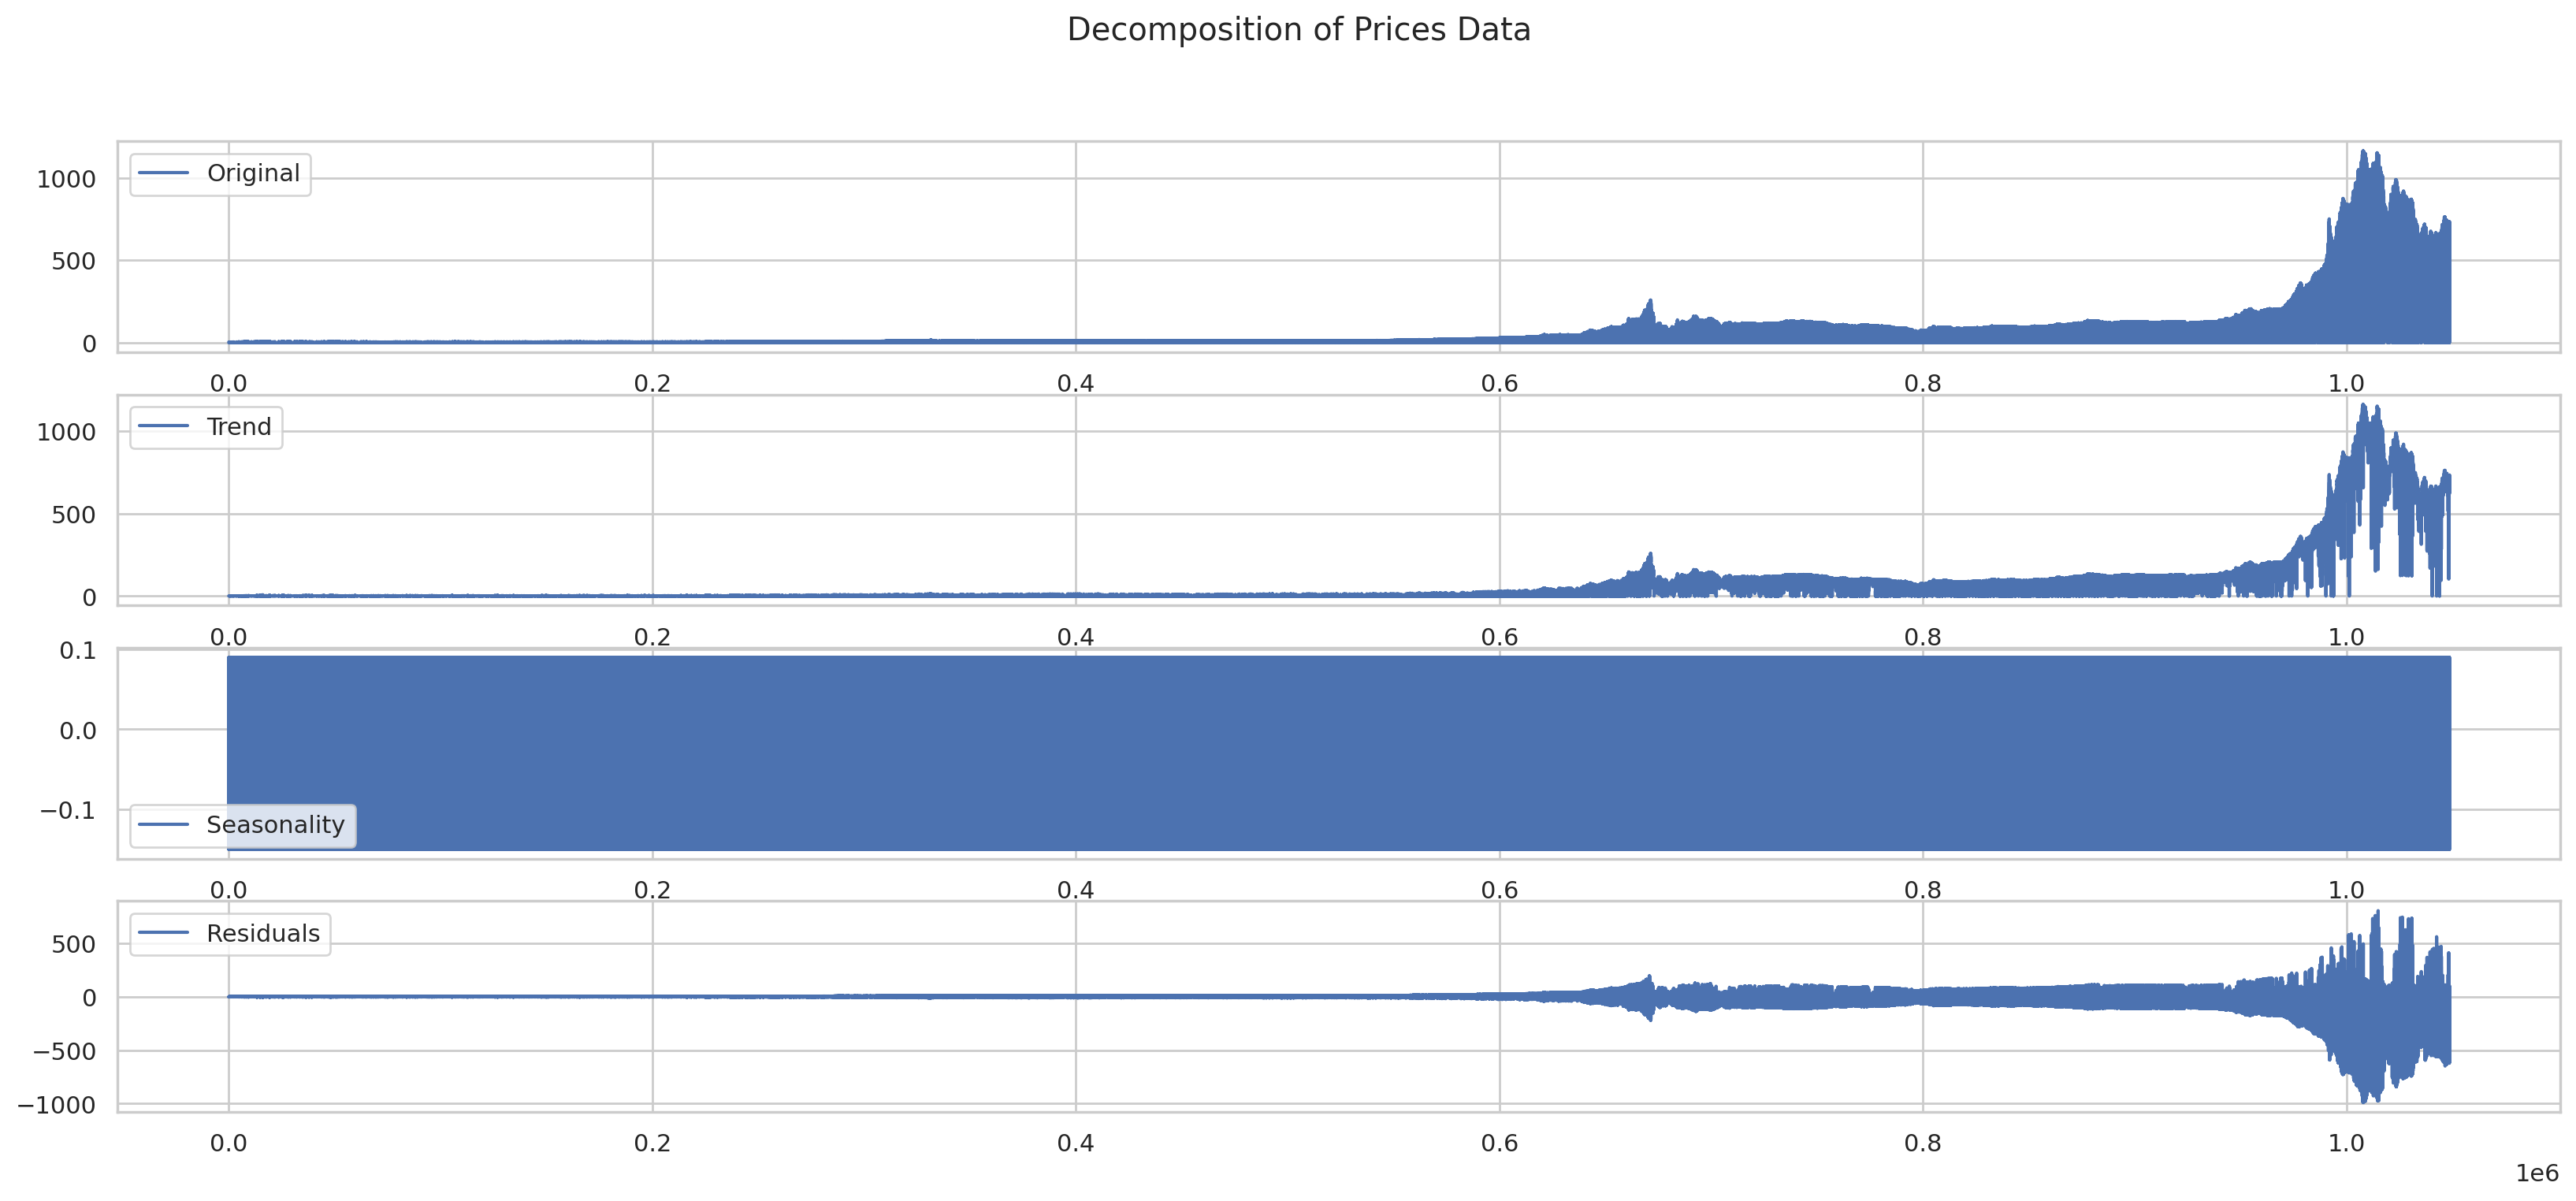

In [55]:
#seasonality by monthly
decomposition = sm.tsa.seasonal_decompose(data.Weighted_Price,period=7)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = plt.figure(figsize=(20,8))

plt.subplot(411)
plt.plot(data.Weighted_Price, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

fig.suptitle('Decomposition of Prices Data')
plt.show()

In [56]:
data.Timestamp = pd.to_datetime(data.Timestamp, unit = 's')
data.index = data.Timestamp
data = data.resample('D').mean()

<ipython-input-56-b77f80587f93>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.resample('D').mean()


<Figure size 1400x600 with 0 Axes>

<Axes: xlabel='Timestamp', ylabel='Weighted_Price'>

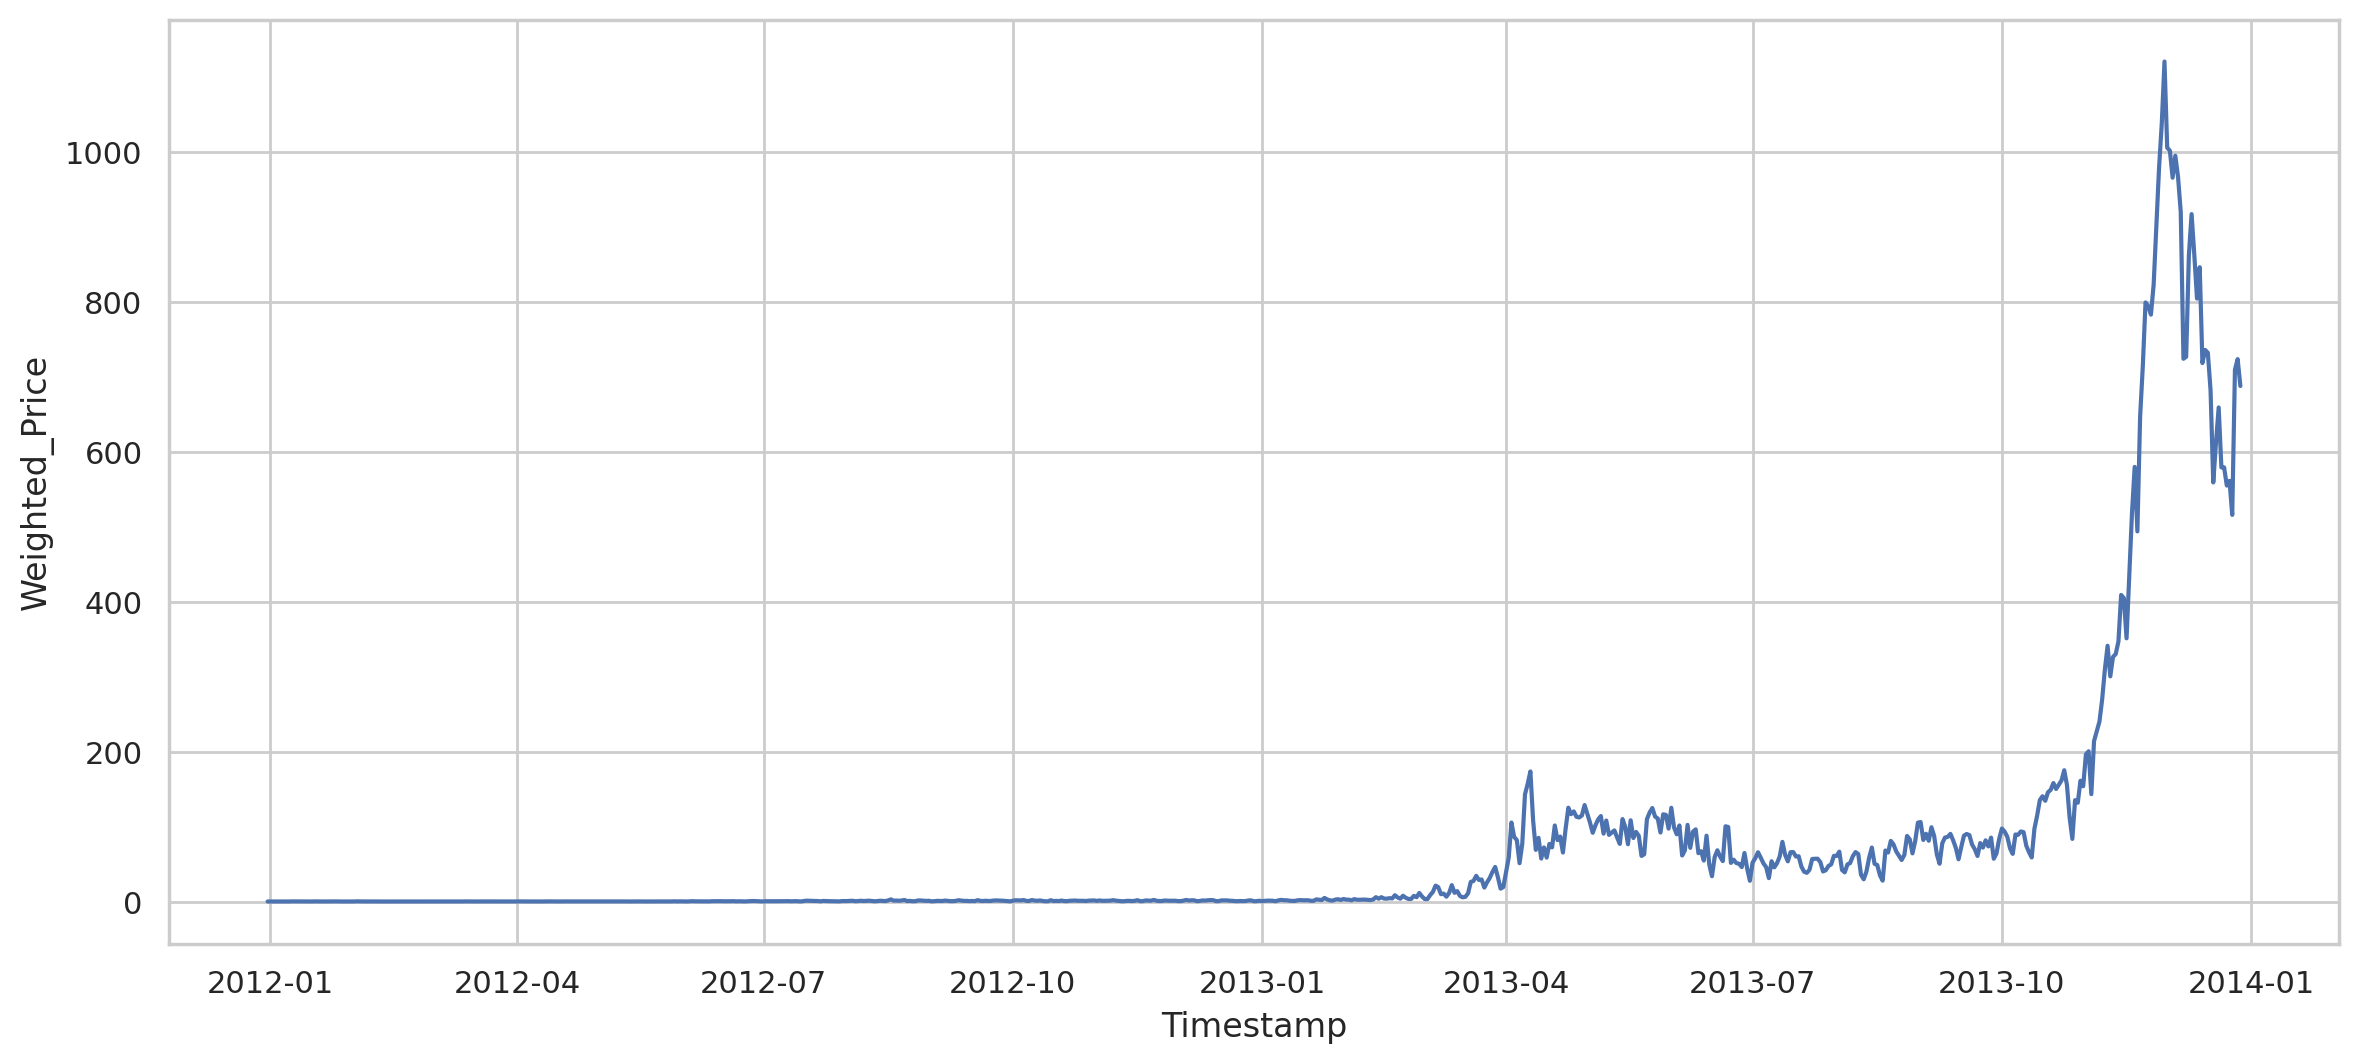

In [57]:
price=data["Weighted_Price"]
plt.figure(figsize = (14,6))
sns.lineplot(x = data.index, y = price)

In [58]:
def decompose(series):
    plt.figure(figsize = (14,7))
    seasonal_decompose(series).plot()
    plt.show()

def DFTest(series):
    testdf = adfuller(series)
    print("DF test p-value : %.16f" %testdf[1] )


def plots(series):
    plt.figure(figsize = (10,6))
    sns.lineplot(data = series, color = 'blue', label = 'observed line plot')
    sns.lineplot(data = series.rolling(window = 12).mean(), color = 'green', label = 'rolling mean, window -12')
    sns.lineplot(data = series.rolling(window = 12).std(), color = 'black', label = 'std deviation, window -12')

In [59]:
print(price.isnull().sum())

0


In [60]:
price = price.fillna(method='ffill')

In [ ]:
data = data.fillna(data.mean())

DF Test->
DF test p-value : 0.9949879677077891


<Figure size 1400x700 with 0 Axes>

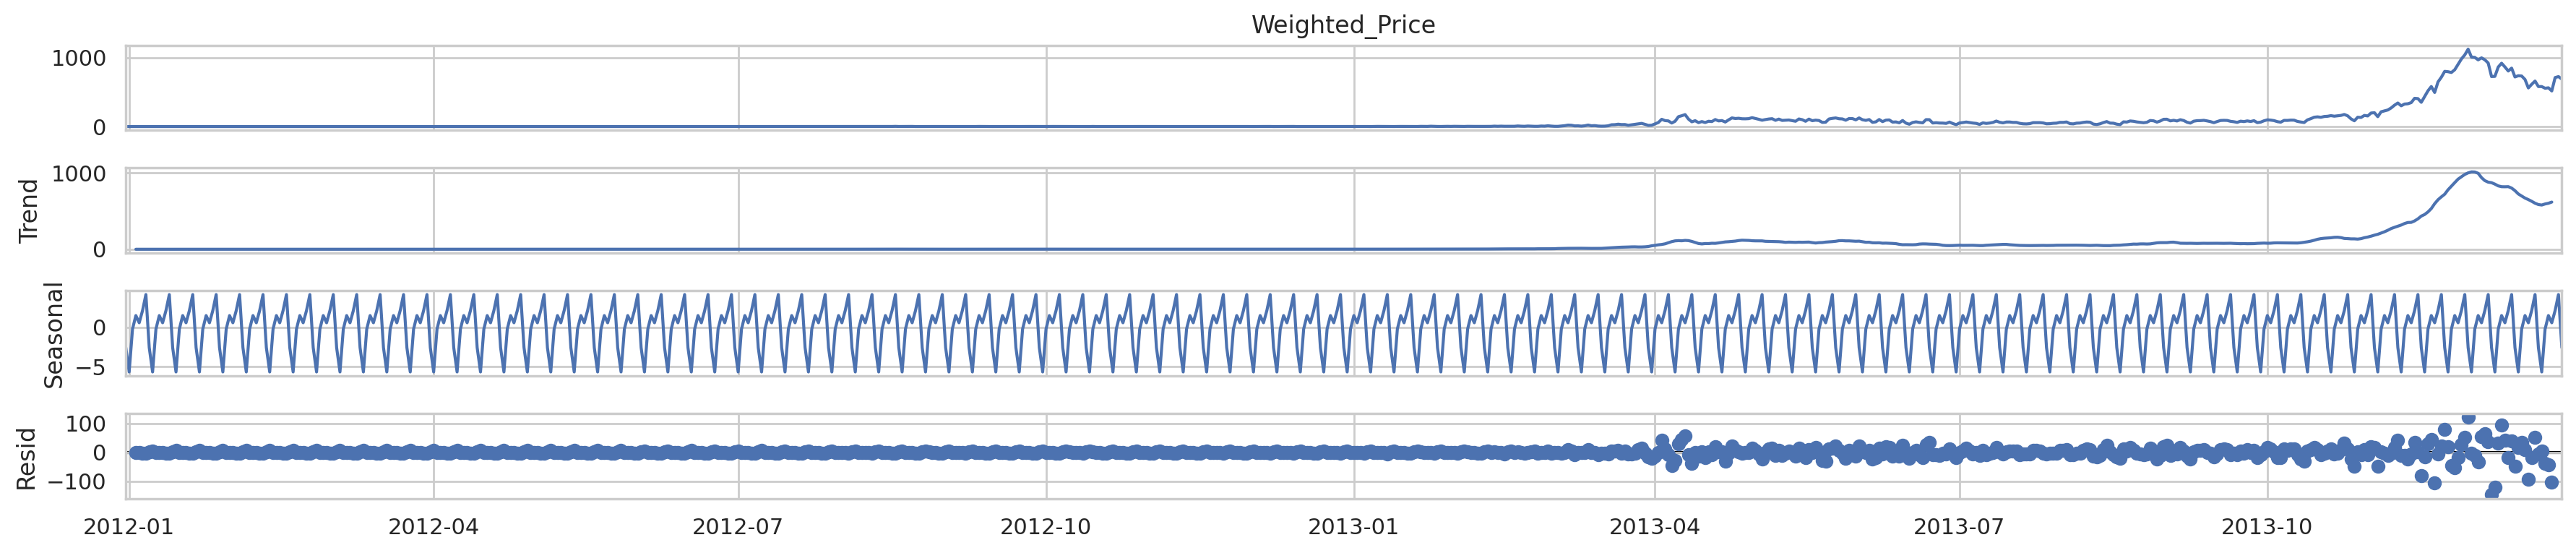

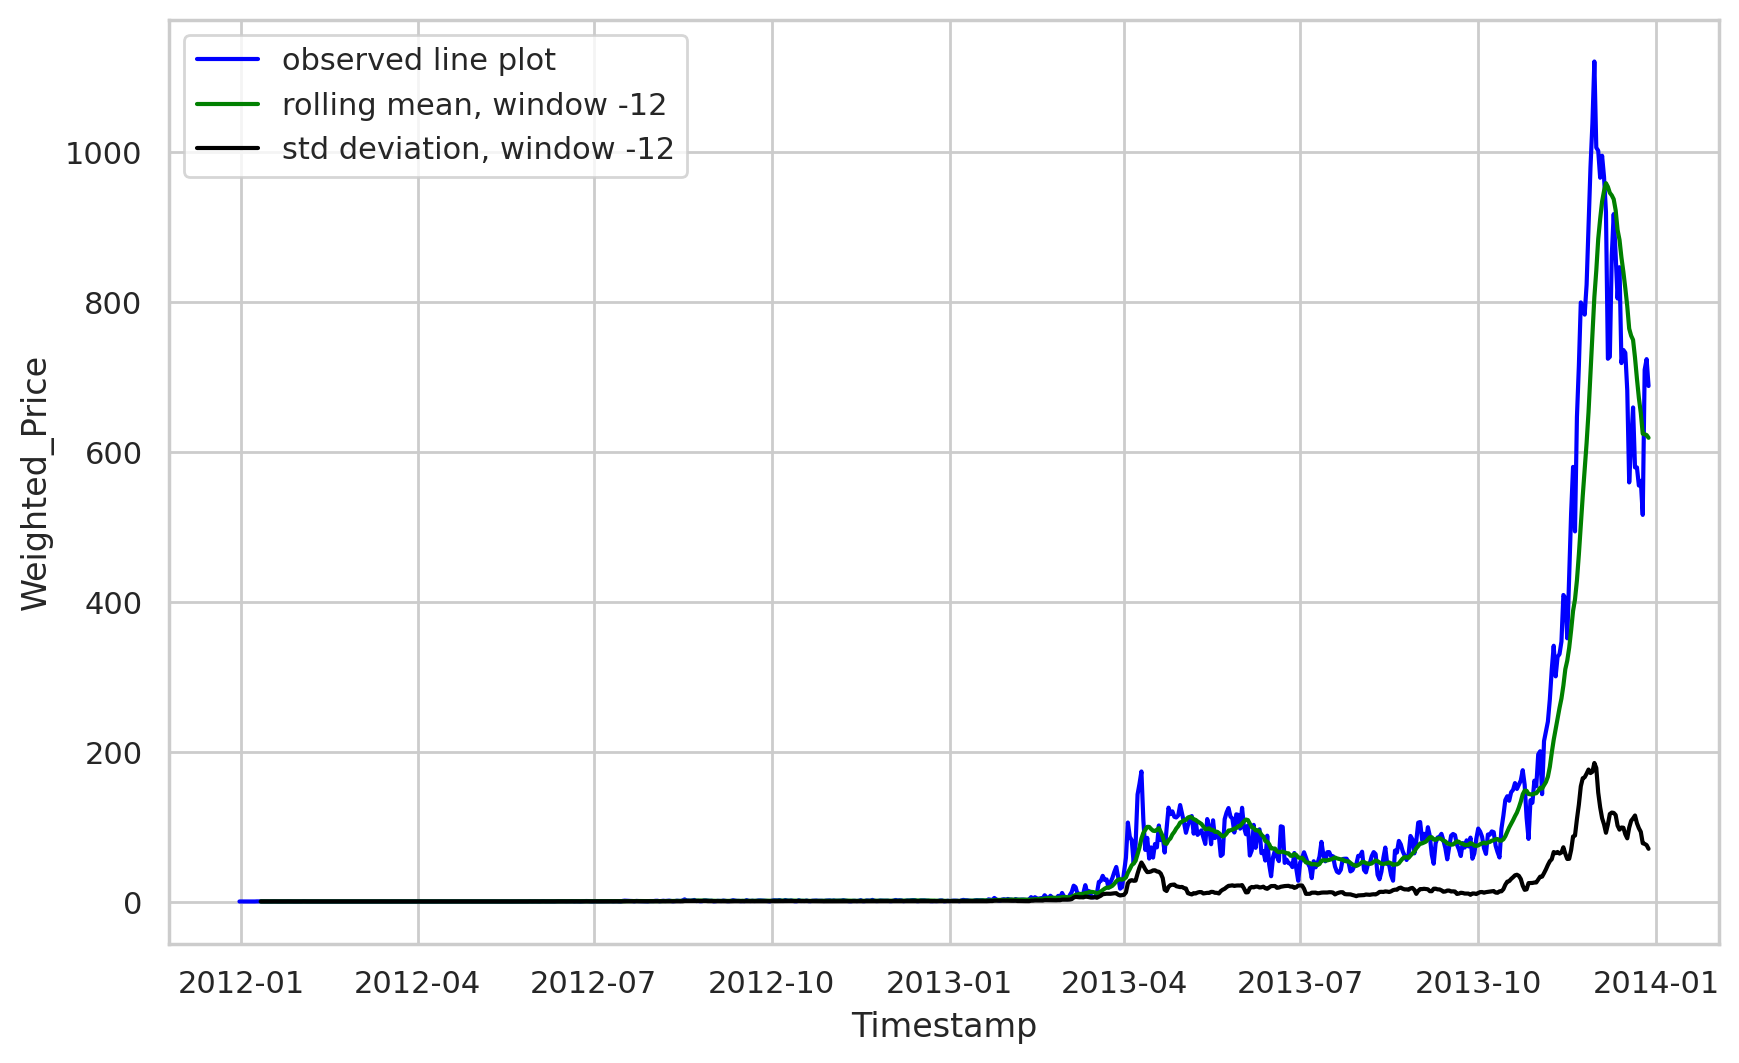

In [61]:
print("DF Test->")
#running tests
DFTest(price)
decompose(price)
plots(price)

<Figure size 1400x700 with 0 Axes>

<Axes: >

<Axes: >

<Axes: >

<Axes: >

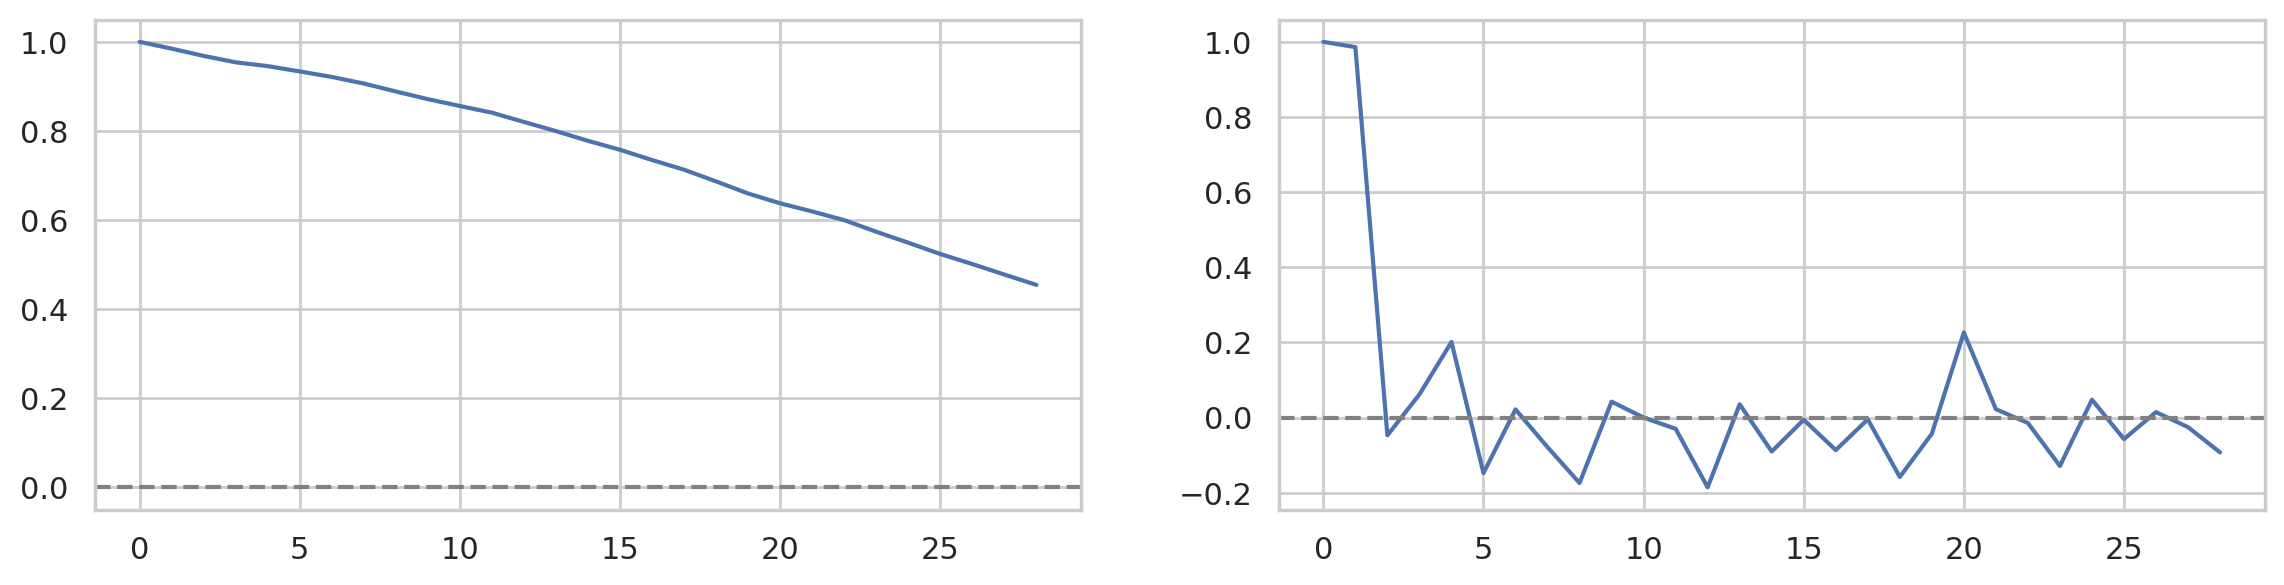

In [62]:
plt.figure(figsize = (14,7))
a = acf(price)
p = pacf(price)

plt.subplot(221)
sns.lineplot(data = a)
plt.axhline(y=0, linestyle='--', color='gray')

plt.subplot(222)
sns.lineplot(data = p)
plt.axhline(y=0, linestyle='--', color='gray')

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'Bitcoin Closing Prices vs. Volume')

Text(0.5, 0, 'Closing Price')

Text(0, 0.5, 'Volume (BTC)')

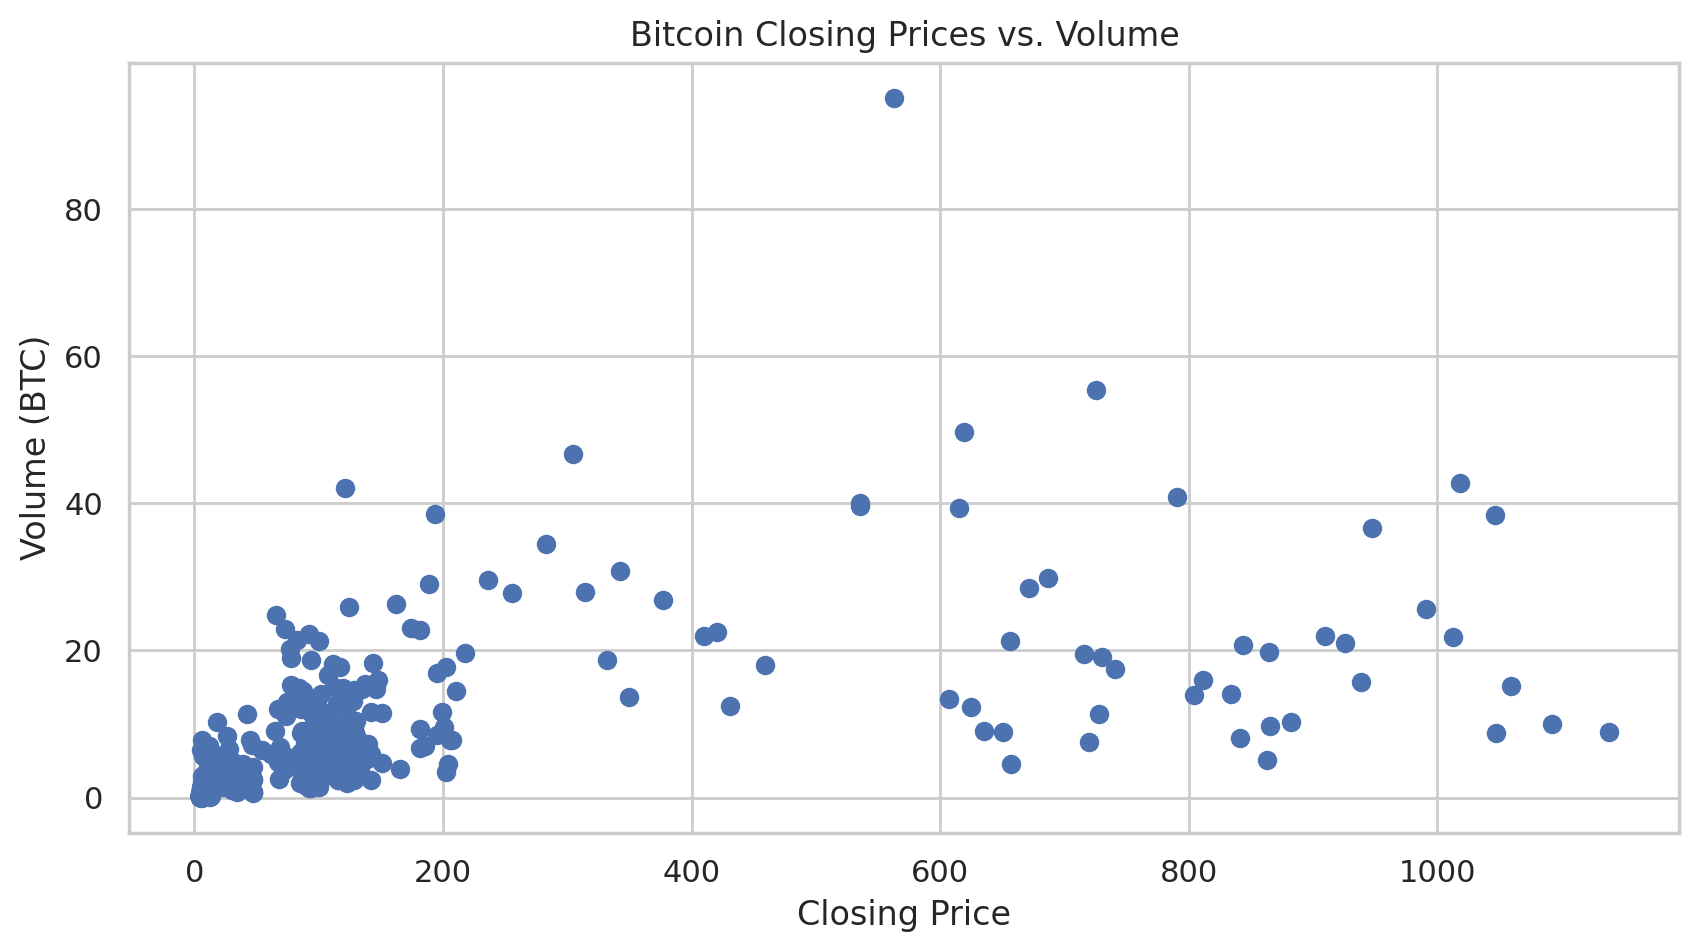

In [63]:
plt.figure(figsize=(10, 5))
plt.scatter(data['Close'], data['Volume_(BTC)'])
plt.title('Bitcoin Closing Prices vs. Volume')
plt.xlabel('Closing Price')
plt.ylabel('Volume (BTC)')
plt.grid(True)
plt.show()

In [64]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [65]:
# Split data into train and test sets
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

In [66]:
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data[['Weighted_Price']])
scaled_test_data = scaler.transform(test_data[['Weighted_Price']])

In [67]:
# ARIMA model
arima_model = ARIMA(train_data['Close'], order=(10, 1, 7))
arima_model_fit = arima_model.fit()
arima_predictions = arima_model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [68]:
# SARIMA model
sarima_model = SARIMAX(train_data['Weighted_Price'], order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))
sarima_model_fit = sarima_model.fit()
sarima_predictions = sarima_model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [69]:
# LSTM model
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(128, input_shape=(1, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

lstm_model = create_lstm_model()
lstm_history = lstm_model.fit(np.expand_dims(scaled_train_data, axis=-1),
                              np.expand_dims(scaled_train_data, axis=-1),
                              epochs=10, batch_size=1, verbose=0)
lstm_predictions = lstm_model.predict(np.expand_dims(scaled_test_data, axis=-1))

5/5 [==============================] - 1s 3ms/step


In [70]:
# Calculate RMSE for each model
arima_rmse = np.sqrt(mean_squared_error(test_data['Weighted_Price'], arima_predictions))
sarima_rmse = np.sqrt(mean_squared_error(test_data['Weighted_Price'], sarima_predictions))
lstm_rmse = np.sqrt(mean_squared_error(test_data['Weighted_Price'], lstm_predictions))

# Print the RMSE values
print(f"ARIMA RMSE: {arima_rmse}")
print(f"SARIMA RMSE: {sarima_rmse}")
print(f"LSTM RMSE: {lstm_rmse}")


ARIMA RMSE: 375.0042349060515
SARIMA RMSE: 395.6902954650171
LSTM RMSE: 432.1520190451423


<Figure size 1000x600 with 0 Axes>

<BarContainer object of 3 artists>

Text(0.5, 1.0, 'RMSE Comparison of Prediction Models')

Text(0.5, 0, 'Model')

Text(0, 0.5, 'RMSE')

([0, 1, 2], [Text(0, 0, 'ARIMA'), Text(1, 0, 'SARIMA'), Text(2, 0, 'LSTM')])

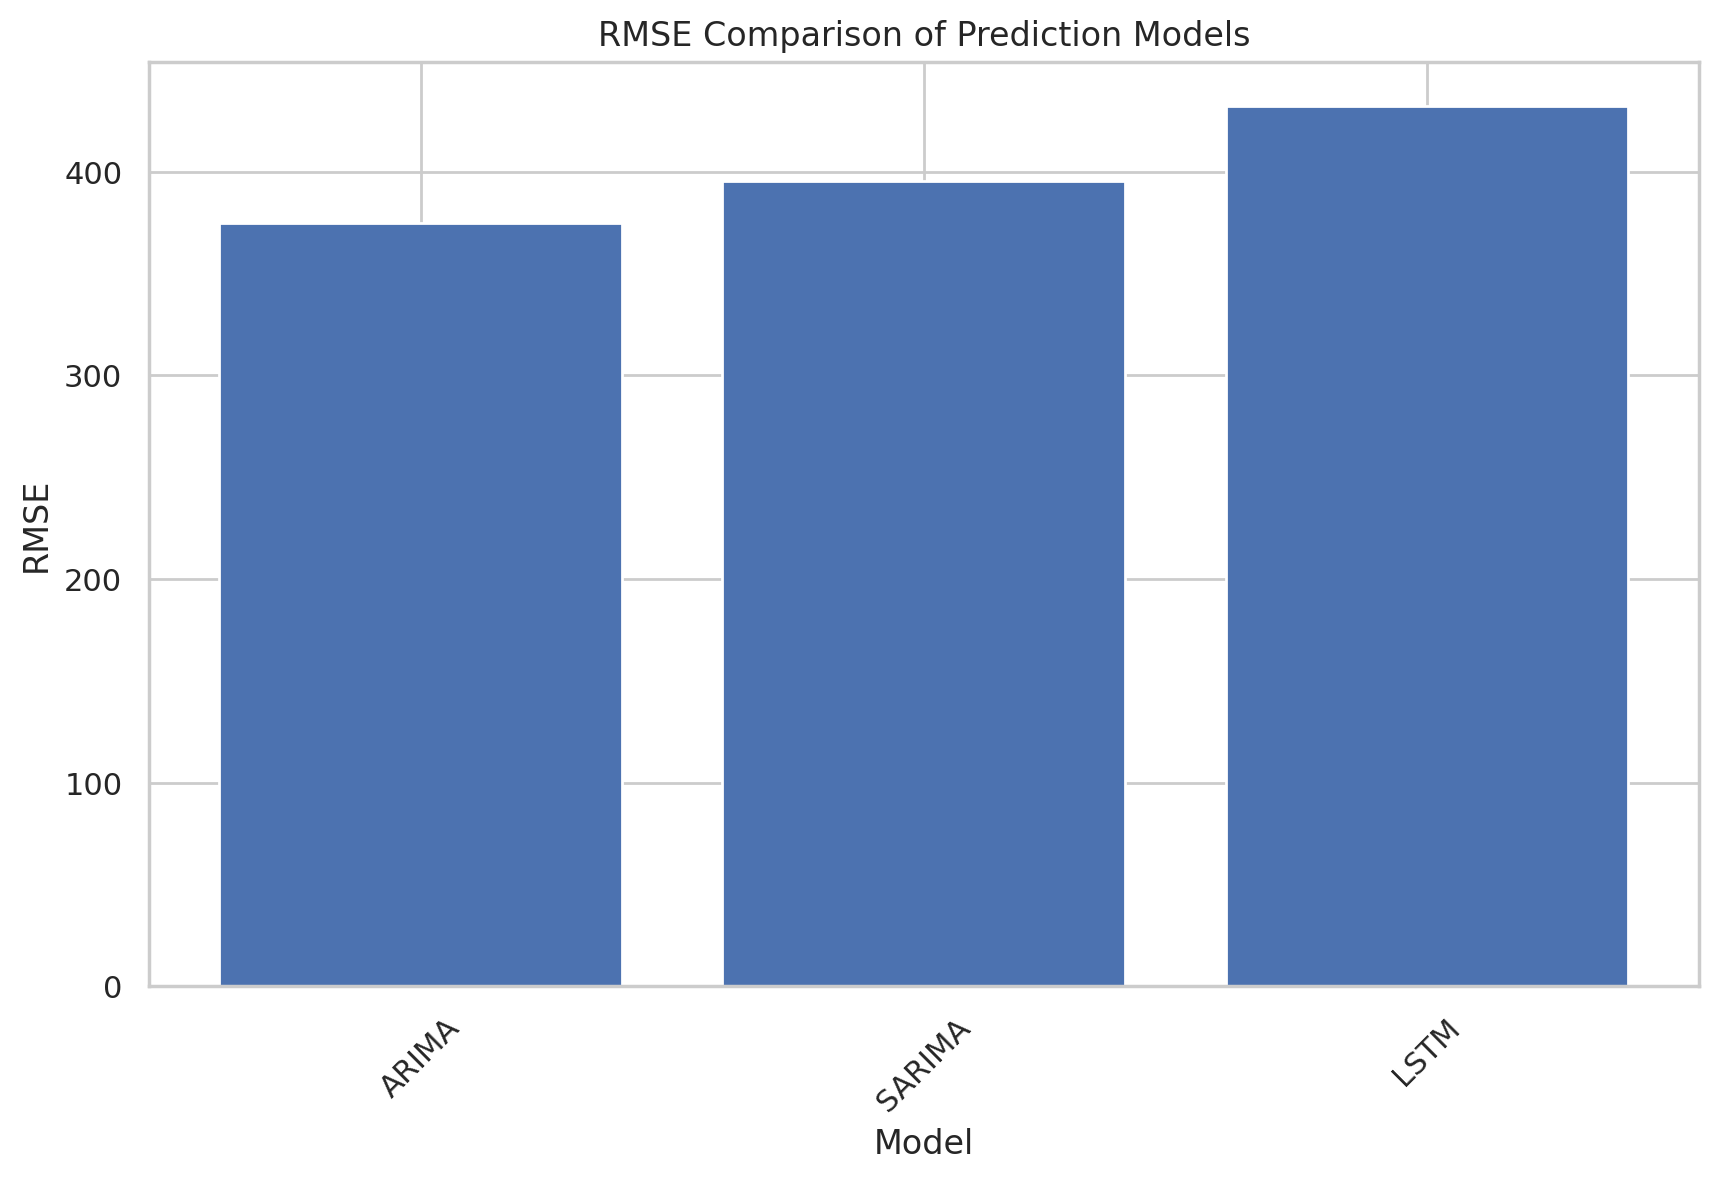

In [71]:
# Define the models and RMSE values
models = ['ARIMA', 'SARIMA', 'LSTM']
rmse_values = [arima_rmse, sarima_rmse, lstm_rmse]

# Plot the bar graph
plt.figure(figsize=(10, 6))
plt.bar(models, rmse_values)
plt.title('RMSE Comparison of Prediction Models')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
